<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Overlap-of-species" data-toc-modified-id="Overlap-of-species-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overlap of species</a></span></li></ul></li><li><span><a href="#Mapping-gene-annotations-to-functions" data-toc-modified-id="Mapping-gene-annotations-to-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Mapping gene annotations to functions</a></span><ul class="toc-item"><li><span><a href="#COG" data-toc-modified-id="COG-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>COG</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Dendrograms" data-toc-modified-id="Dendrograms-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Dendrograms</a></span><ul class="toc-item"><li><span><a href="#Genes-per-COG-cat" data-toc-modified-id="Genes-per-COG-cat-5.1.2.1"><span class="toc-item-num">5.1.2.1&nbsp;&nbsp;</span>Genes per COG cat</a></span></li><li><span><a href="#Genes-per-COG-category" data-toc-modified-id="Genes-per-COG-category-5.1.2.2"><span class="toc-item-num">5.1.2.2&nbsp;&nbsp;</span>Genes per COG category</a></span></li></ul></li></ul></li><li><span><a href="#pfam" data-toc-modified-id="pfam-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>pfam</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Genes-per-pfam" data-toc-modified-id="Genes-per-pfam-5.2.1.1"><span class="toc-item-num">5.2.1.1&nbsp;&nbsp;</span>Genes per pfam</a></span></li><li><span><a href="#Genes-per-pfam-group" data-toc-modified-id="Genes-per-pfam-group-5.2.1.2"><span class="toc-item-num">5.2.1.2&nbsp;&nbsp;</span>Genes per pfam group</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Create tables of genome gene content
  * gene content aggregated by functional grouping (eg., COG)
* Using genome genes annotated to UniRef50 via Struo2 (mmseqs search)
* Creating gene content dendrograms

# Var

In [1]:
work_dir = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/'

# gene annotations for all genomes
annot_tbl_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/Struo2/humann3/UniRef50/genome_reps_filt_annot.tsv.gz'

# humann3 utility mapping 
util_map_dir = '/ebio/abt3_projects/databases_no-backup/humann3/201901/utility_mapping/'
## COG
util_map_cog_file = file.path(util_map_dir, 'map_eggnog_uniref50.txt.gz')
util_map_cog_h_file = file.path(util_map_dir, 'hierarchy', 'COG.tsv')
## pfam
util_map_pfam_file = file.path(util_map_dir, 'map_pfam_uniref50.txt.gz')
util_map_pfam_h_file = file.path(util_map_dir, 'hierarchy', 'pfam.tsv')

# bracken counts
brk_file = '/ebio/abt3_projects2/global_metagenome_diversity/data/global_metagenomes/diversity/bracken_filt2.qs'

# sample metadata
meta_file = '/ebio/abt3_projects2/global_metagenome_diversity/data/public_data_retireval/CurMetDat-metagenomes/files/metadata/Filtered_CurMetDat_ff.tsv'

# GTDBr89 genome metadata
genome_meta_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/metadata_1per-GTDB-Spec_gte50comp-lt5cont_wtaxID_wPath.tsv'

# trees
## GTDB phylogeny
phy_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/phylogeny/ar122-bac120_r89_1per-GTDB-Spec_gte50comp-lt5cont_rn.nwk'
## trait phylogeny
phy_trt_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG//phenotype/predictions_flat_majority-votes_combined_jaccard_rn.nwk'

# params
threads = 8

# Init

In [4]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(LeyLabRMisc)

In [5]:
df.dims()
data.table::setDTthreads(threads)

# Load

## Overlap of species

In [6]:
# Bracken count table
brk = qs::qread(brk_file, nthreads=threads) %>%
    distinct.(name) %>%
    mutate.(name = gsub(' ', '_', name))
# number of species
brk %>% unique_n('Species', name) 

No. of unique Species: 3550 


In [7]:
# struo2 gene annotations
specs = Fread(annot_tbl_file) %>% 
    distinct.(species) 
specs %>% unique_n('Species', species)

In [ ]:
# overlap with bracken count table
overlap(brk$name, specs$species)

In [ ]:
# overlap with genome phylogeny
phy = ape::read.tree(phy_file)
overlap(phy$tip.label, specs$species)

In [13]:
#send_email('http://127.0.0.1:9702/notebooks/ipynb/01_data_explore/08a_genome_gene_content_UniRef50.ipynb#')

Sending email to: nyoungblut@tuebingen.mpg.de



# Mapping gene annotations to functions

In [14]:
# python script for converting unstructured tables to long table
exe = file.path(util_map_dir, 'map2long.py')
exe

[1] "/ebio/abt3_projects/databases_no-backup/humann3/201901/utility_mapping//map2long.py"

In [15]:
# showing code
cat_file(exe)

#!/usr/bin/env python
from __future__ import print_function
import os
import sys
import gzip
import argparse
import logging

desc = 'Converting humann3 utility mapping file to a long table format'
epi = """DESCRIPTION:
gzip input or uncompressed is OK.
Output written to STDOUT.
You can use this script for reading into R via data.table::fread:
```
data.table::fread(cmd = './map2long.py map_ko_uniref50.txt.gz')
```
"""
parser = argparse.ArgumentParser(description=desc,
                                 epilog=epi,
                                 formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument('map_file', metavar='map_file', type=str,
                    help='humann3 utility mapping file')
parser.add_argument('--version', action='version', version='0.0.1')
#For default: (default: %(default)s)


logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.DEBUG)
# logging.info()

def _open(infile):
    if infile.endswith('.gz'):
        return gzip.open(infile,

## COG

In [16]:
# loading mapping table 
cmd = paste(exe, util_map_cog_file, sep=' ')
cog_map = Fread(cmd=cmd, sep='\t', header=FALSE) %>%
    filter.(!grepl('^(arCOG|ENOG|KOG)', V1))
colnames(cog_map) = c('COG', 'UniRefID')
cog_map

COG,UniRefID
<chr>,<chr>
COG0001,UniRef50_A0A075R537
COG0001,UniRef50_A0A077D605
⋮,⋮
COG5665,UniRef50_Q7ZVL4
COG5665,UniRef50_W4XW05


In [17]:
# COG categories
util_map_cog_h = Fread(util_map_cog_h_file, header=FALSE) %>%
    select.(-V2)
colnames(util_map_cog_h) = c('COG', 'COG_cat', 'COG_cat_name', 'COG_cat_group')
util_map_cog_h

COG,COG_cat,COG_cat_name,COG_cat_group
<chr>,<chr>,<chr>,<chr>
COG0001,H,Coenzyme transport and metabolism,Metabolism
COG0002,E,Amino acid transport and metabolism,Metabolism
⋮,⋮,⋮,⋮
COG5664,O,"Post-translational modification, protein turnover, and chaperones",Cellular processes and signaling
COG5665,K,Transcription,Information storage and processing


In [181]:
# annotations
#cmd = paste('gunzip -c', annot_tbl_file, '| head -n 500001', sep=' ') 
cmd = paste('gunzip -c', annot_tbl_file, sep=' ') 
COG_annot = Fread(cmd=cmd) %>%
    distinct.(seq_uuid, genome_name, annotation, species) %>%
    #inner_join.(brk, c('species'='name')) %>%
    inner_join.(cog_map, c('annotation'='UniRefID')) %>%
    left_join.(util_map_cog_h, c('COG')) 
COG_annot %>% unique_n('Species', species)
COG_annot

No. of unique Species: 23333 


seq_uuid,genome_name,annotation,species,COG,COG_cat,COG_cat_name,COG_cat_group
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
29ca1f2214014aecbfc2e0b4a7f7806d,GCA_003313305.1_ASM331330v1_genomic,UniRef50_A0A075R537,s__Vallitalea_guaymasensis,COG0001,H,Coenzyme transport and metabolism,Metabolism
ac8e06fd7ae340619e7b7666c535b3c1,GCA_000948985.1_ASM94898v1_genomic,UniRef50_A0A075R537,s__Thalassomonas_viridans,COG0001,H,Coenzyme transport and metabolism,Metabolism
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
d9b9a1bd4c3f422e9257a71d9c3dd2b3,GCA_900169785.1_ASM90016978v1_genomic,UniRef50_F0L7H1,s__Rhizobium_sullae,COG5664,O,"Post-translational modification, protein turnover, and chaperones",Cellular processes and signaling
ba149487a7ef45fdab119576222c0e77,GCA_900110205.1_IMG-taxon_2671180023_annotated_assembly_genomic,UniRef50_F0L7H1,s__Rhizobium_tibeticum,COG5664,O,"Post-translational modification, protein turnover, and chaperones",Cellular processes and signaling


### Summary

In [182]:
# number of COG-annotated genes per genome
COG_annot %>%
    distinct.(seq_uuid, species, COG) %>%
    summarize.(n_cog = n.(), by=species) %>%
    .$n_cog %>% summary_x('COG annot. genes per genome')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
COG annot. genes per genome,1,218,338,359.8773,502,1165,396.931,162.047


In [183]:
# number of different COG annotationsper genome
COG_annot %>%
    distinct.(species, COG) %>%
    summarize.(n_cog = n.(), by=species) %>%
    .$n_cog %>% summary_x('COG annot. per genome')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
COG annot. per genome,1,203,306,315.9079,440,773,258.037,105.343


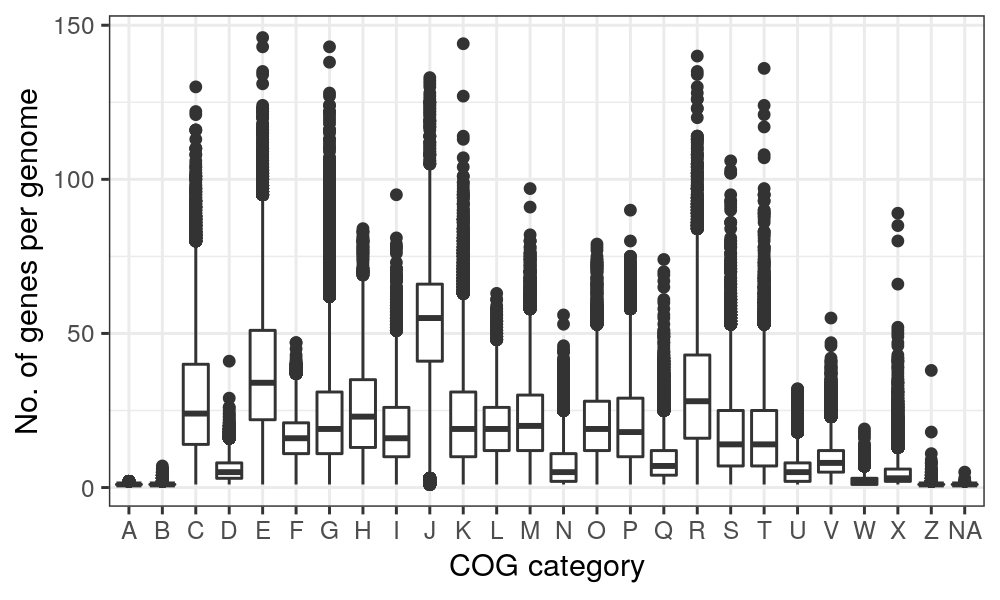

In [184]:
# number of genes per COG category per genome
p = COG_annot %>%
    distinct.(seq_uuid, species, COG, COG_cat) %>%
    summarize.(n_gene = n.(), by=c(species, COG_cat)) %>%
    ggplot(aes(COG_cat, n_gene)) +
    geom_boxplot() +
    labs(x='COG category',
         y='No. of genes per genome') +
    theme_bw()

p.dims(5,3)
plot(p)

### Dendrograms

#### Genes per COG cat

In [185]:
# creating `genome x COG` matrix
m = COG_annot %>%
    distinct.(seq_uuid, species, COG) %>%
    summarize.(n_genes = n.(), by=c(species, COG)) %>%
    pivot_wider.(COG, n_genes) %>%
    mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
    as.data.frame
                   
rownames(m) = m$species
m$species = NULL
m

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,COG0010,⋯,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__0-14-0-20-30-16_sp002779075,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Zymomonas_mobilis,0,0,0,0,0,0,1,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Zymomonas_pomaceae,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,1,0,0,0,0,0


In [186]:
# adding missing species
#to_add = setdiff(brk$name, rownames(m))
to_add = setdiff(phy$tip.label, rownames(m))
cat('Species to add:', length(to_add), '\n')
if(length(to_add) > 0){
    mx = matrix(rep(0, ncol(m) * length(to_add)),
                ncol=ncol(m),
                nrow=length(to_add)) %>%
        as.data.frame
    rownames(mx) = to_add
    colnames(mx) = colnames(m)
    m = rbind(m, mx)
}
m

Species to add: 27 


,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,COG0010,⋯,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__0-14-0-20-30-16_sp002779075,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Bartonella_washoeensis,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__HL-12_sp900177545,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


##### Writing matrix

In [190]:
F = file.path(work_dir, 'genes-per-COG.tsv')
m %>% 
    tibble::rownames_to_column('Taxon') %>%
    write_table(F)

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COG.tsv 


##### Bray-Curtis

In [191]:
fix_dist_NAs = function(D, fill=1){
    D[is.na(D)] = fill
    return(D)
}

In [192]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='bray') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "bray"):
“you have empty rows: their dissimilarities may be meaningless in method “bray””
Warning message in vegan::vegdist(m, method = "bray"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


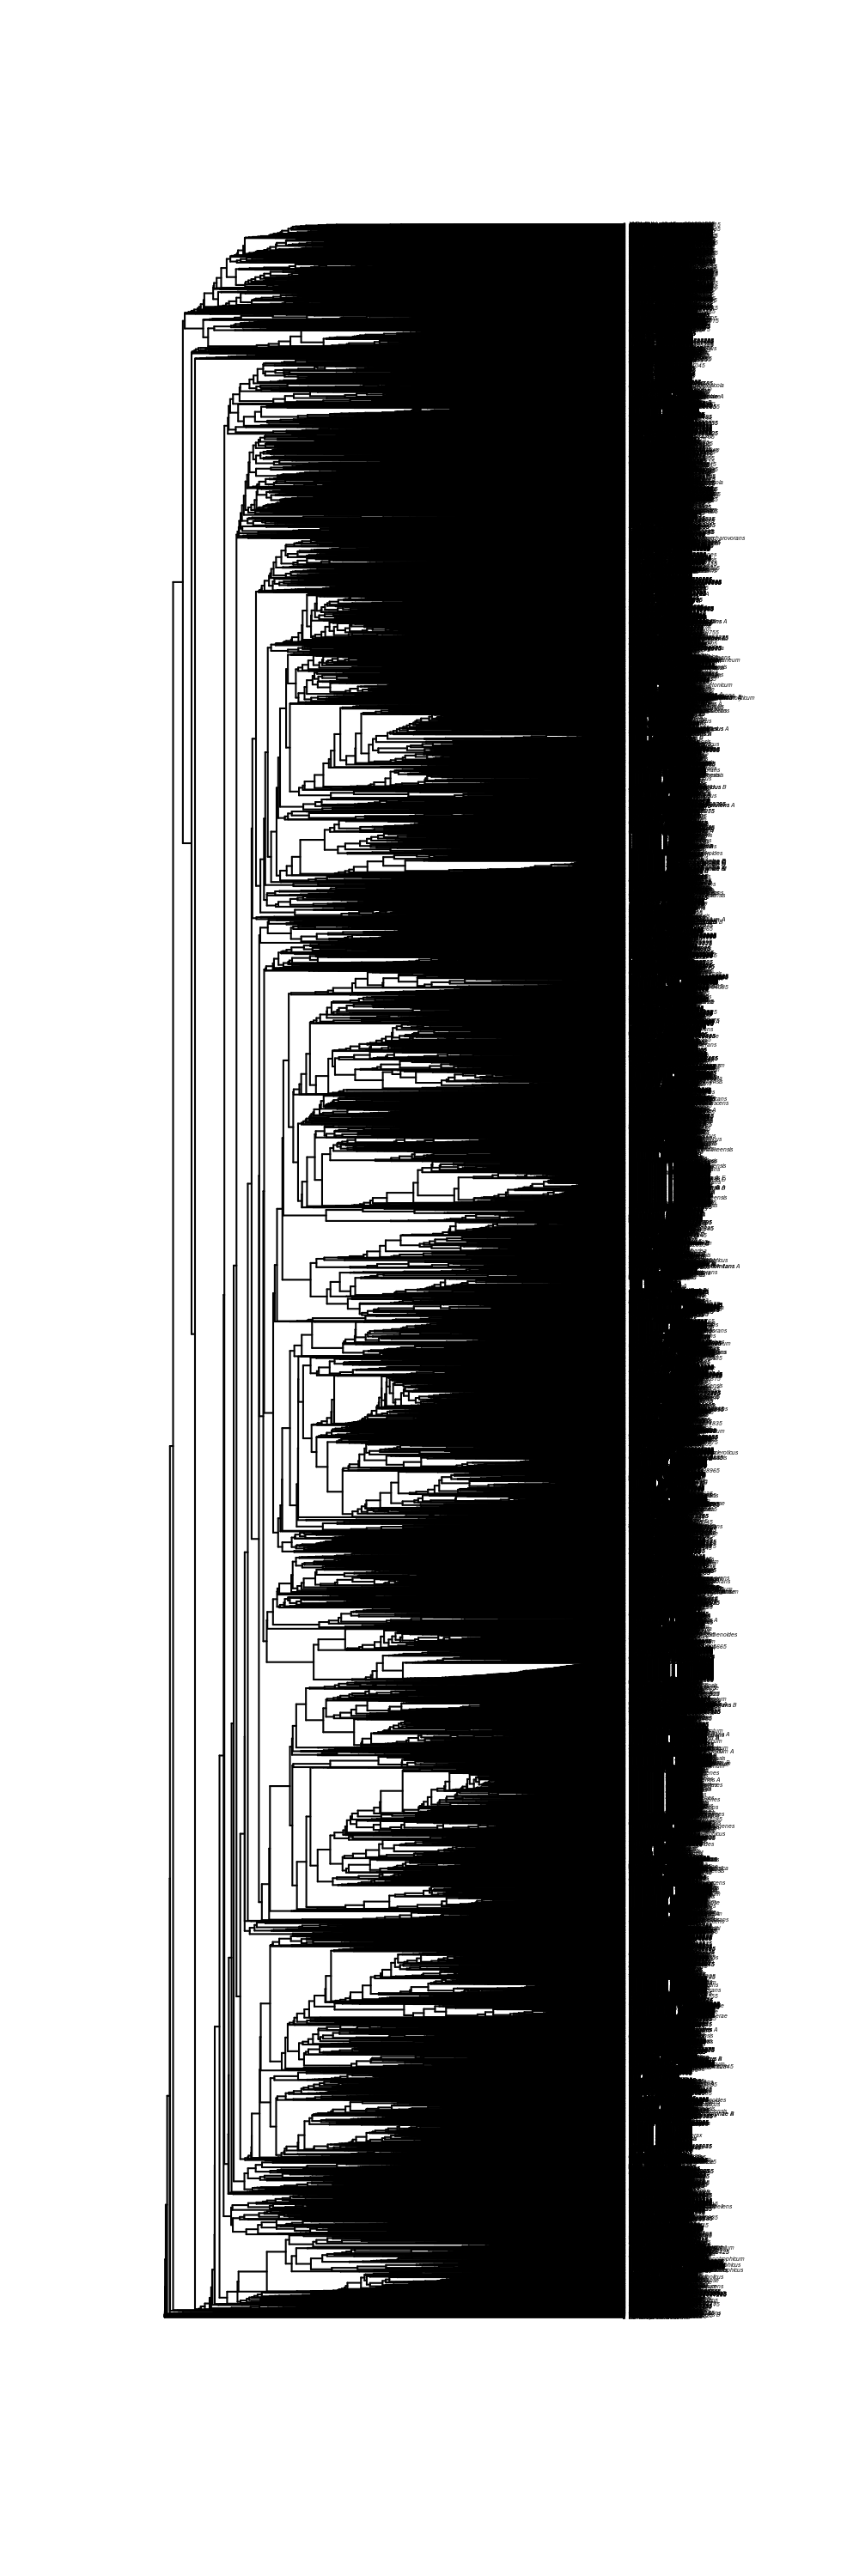

In [193]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.2)

In [194]:
# writing tree
F = file.path(work_dir, 'genes-per-COG_bray.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COG_bray.nwk 


##### Jaccard

In [195]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='jaccard') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "jaccard"):
“you have empty rows: their dissimilarities may be meaningless in method “jaccard””
Warning message in vegan::vegdist(m, method = "jaccard"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


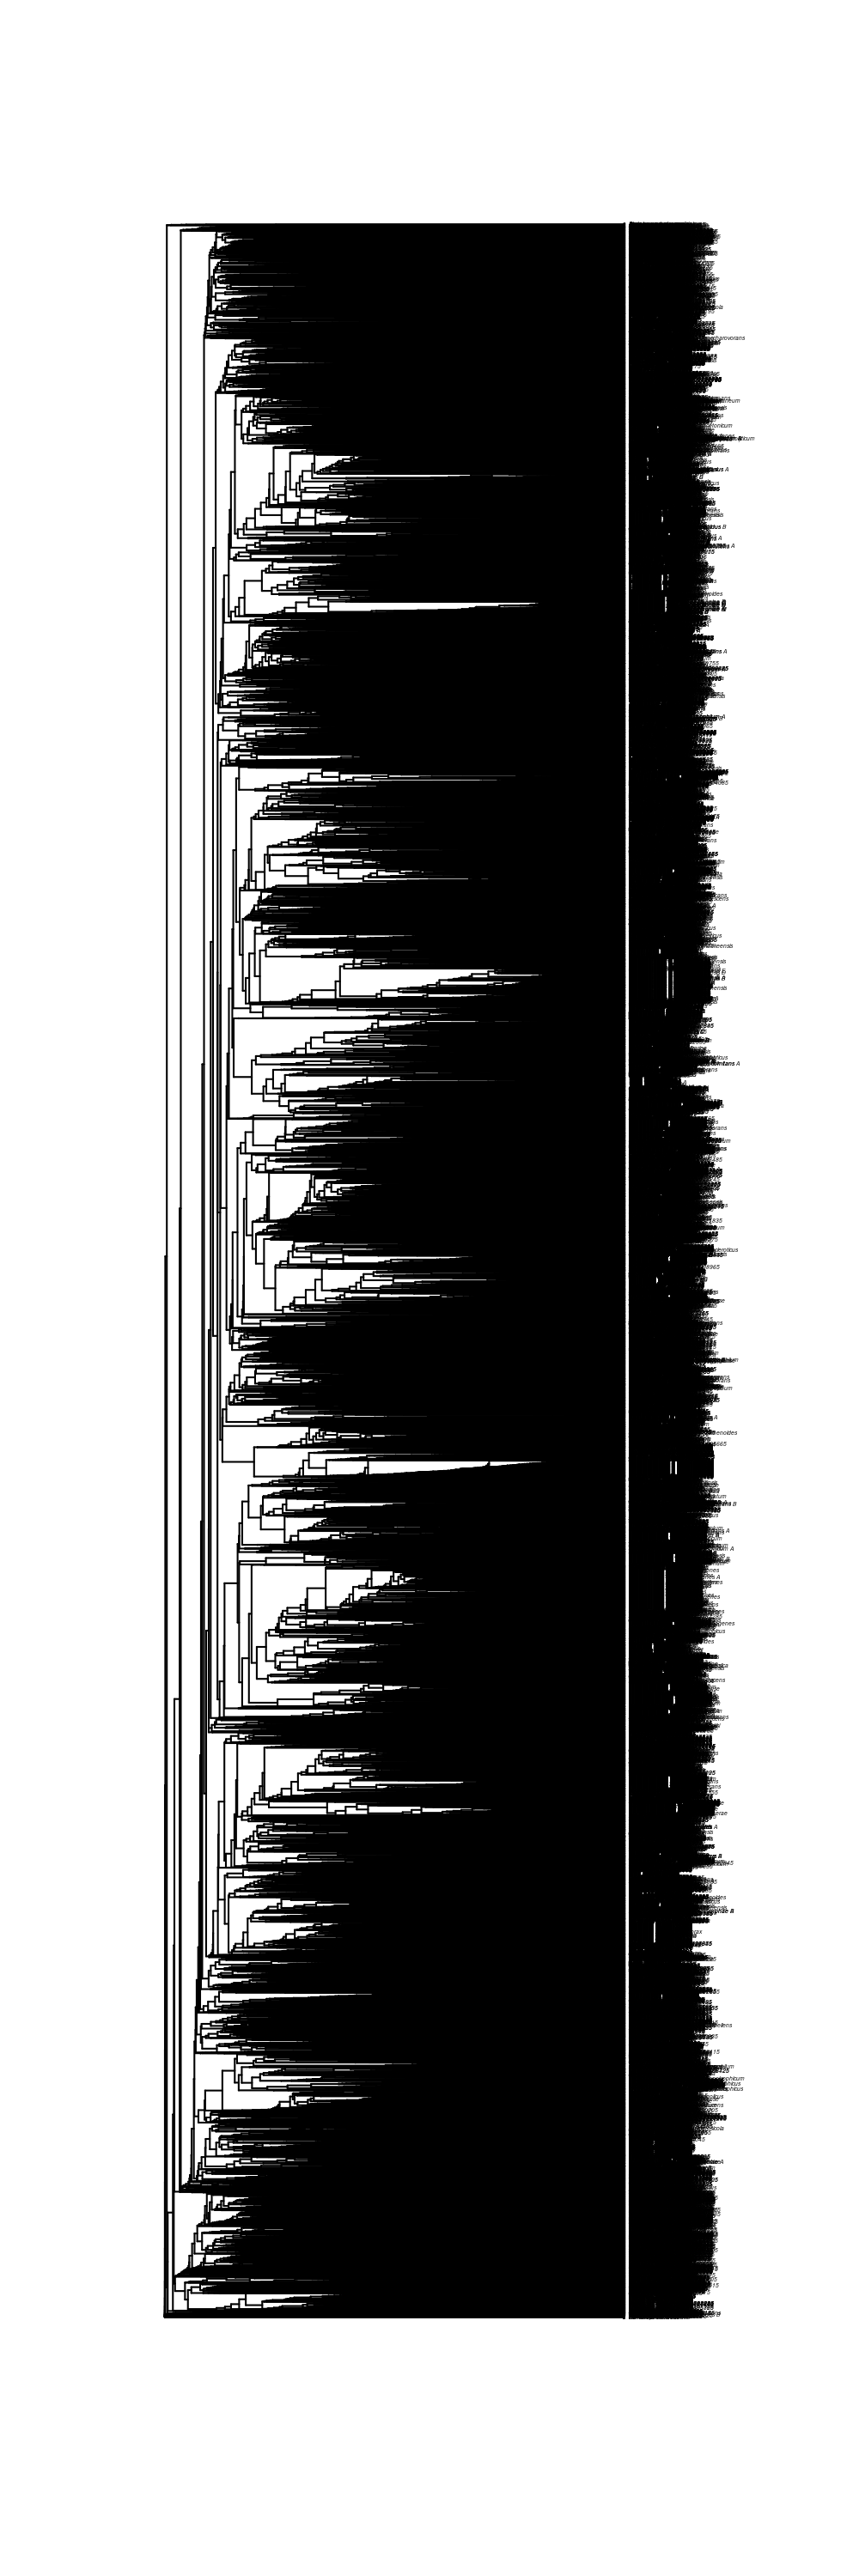

In [196]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.2)

In [197]:
# writing tree
F = file.path(work_dir, 'genes-per-COG_jaccard.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COG_jaccard.nwk 


#### Genes per COG category

In [198]:
# creating `genome x COG_cat` matrix
m = COG_annot %>%
    distinct.(seq_uuid, species, COG_cat) %>%
    filter.(!is.na(COG_cat)) %>%
    summarize.(n_genes = n.(), by=c(species, COG_cat)) %>%
    pivot_wider.(COG_cat, n_genes) %>%
    mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
    as.data.frame
                   
rownames(m) = m$species
m$species = NULL
m

,A,B,C,D,E,F,G,H,I,J,⋯,P,Q,R,S,T,U,V,W,X,Z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,1,0,1,0,0,0,9,⋯,0,0,0,0,0,0,1,0,1,0
s__0-14-0-20-30-16_sp002779075,0,0,0,1,1,1,0,1,1,12,⋯,0,0,5,1,1,0,4,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Zymomonas_mobilis,0,0,16,4,30,14,10,24,15,66,⋯,6,2,13,11,9,7,2,0,0,0
s__Zymomonas_pomaceae,0,0,17,1,24,13,12,15,16,64,⋯,14,3,9,7,9,6,7,0,1,0


In [199]:
# adding missing species
#to_add = setdiff(brk$name, rownames(m))
to_add = setdiff(phy$tip.label, rownames(m))
cat('Species to add:', length(to_add), '\n')
if(length(to_add) > 0){
    mx = matrix(rep(0, ncol(m) * length(to_add)),
                ncol=ncol(m),
                nrow=length(to_add)) %>%
        as.data.frame
    rownames(mx) = to_add
    colnames(mx) = colnames(m)
    m = rbind(m, mx)
}
m

Species to add: 27 


,A,B,C,D,E,F,G,H,I,J,⋯,P,Q,R,S,T,U,V,W,X,Z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,1,0,1,0,0,0,9,⋯,0,0,0,0,0,0,1,0,1,0
s__0-14-0-20-30-16_sp002779075,0,0,0,1,1,1,0,1,1,12,⋯,0,0,5,1,1,0,4,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Bartonella_washoeensis,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__HL-12_sp900177545,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


##### Writing table

In [200]:
F = file.path(work_dir, 'genes-per-COGcat.tsv')
m %>% 
    tibble::rownames_to_column('Taxon') %>%
    write_table(F)

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COGcat.tsv 


##### Bray-Curtis

In [201]:
# creating dendrogram
dnd = vegan::vegdist(m, method='bray') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "bray"):
“you have empty rows: their dissimilarities may be meaningless in method “bray””
Warning message in vegan::vegdist(m, method = "bray"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


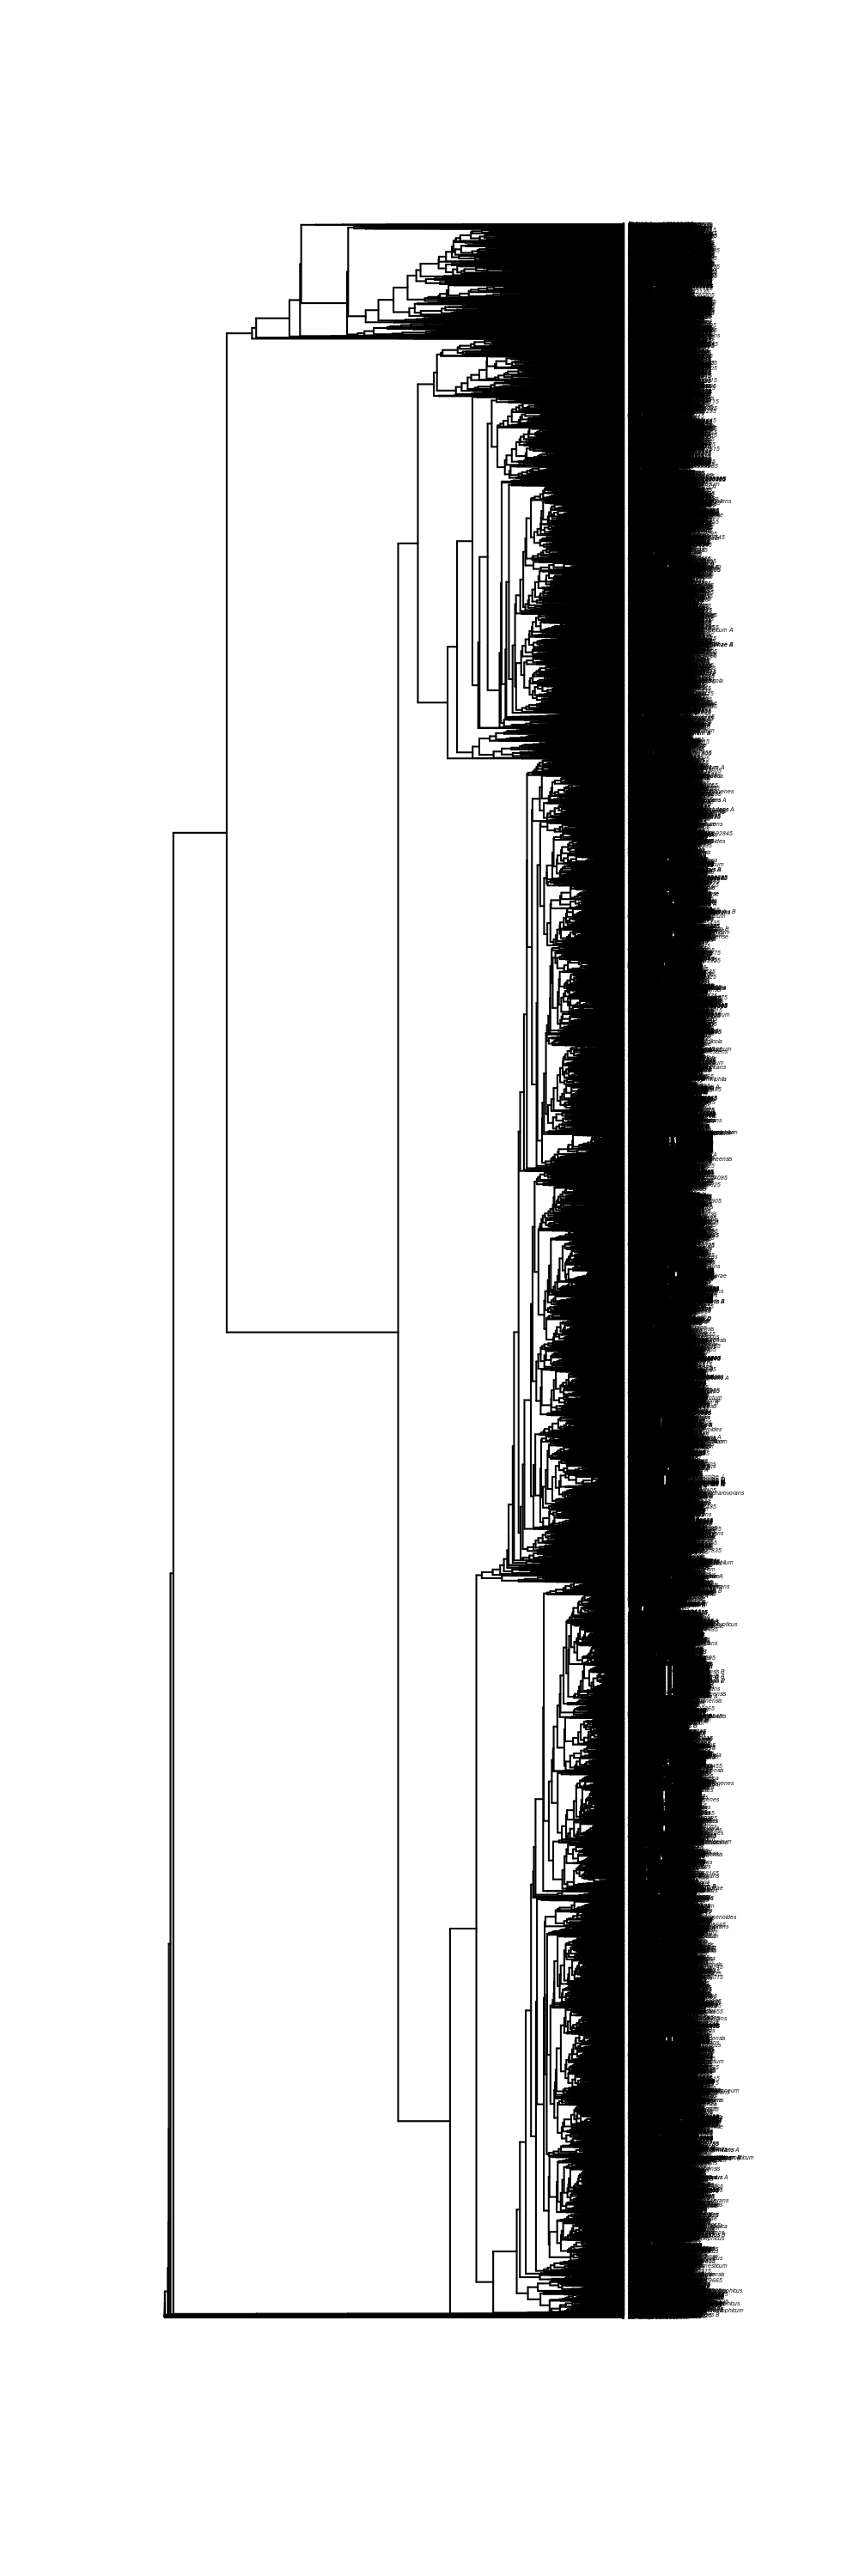

In [202]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.2)

In [203]:
# writing tree
F = file.path(work_dir, 'genes-per-COGcat_bray.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COGcat_bray.nwk 


##### Jaccard

In [204]:
# creating dendrogram
dnd = vegan::vegdist(m, method='jaccard') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "jaccard"):
“you have empty rows: their dissimilarities may be meaningless in method “jaccard””
Warning message in vegan::vegdist(m, method = "jaccard"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


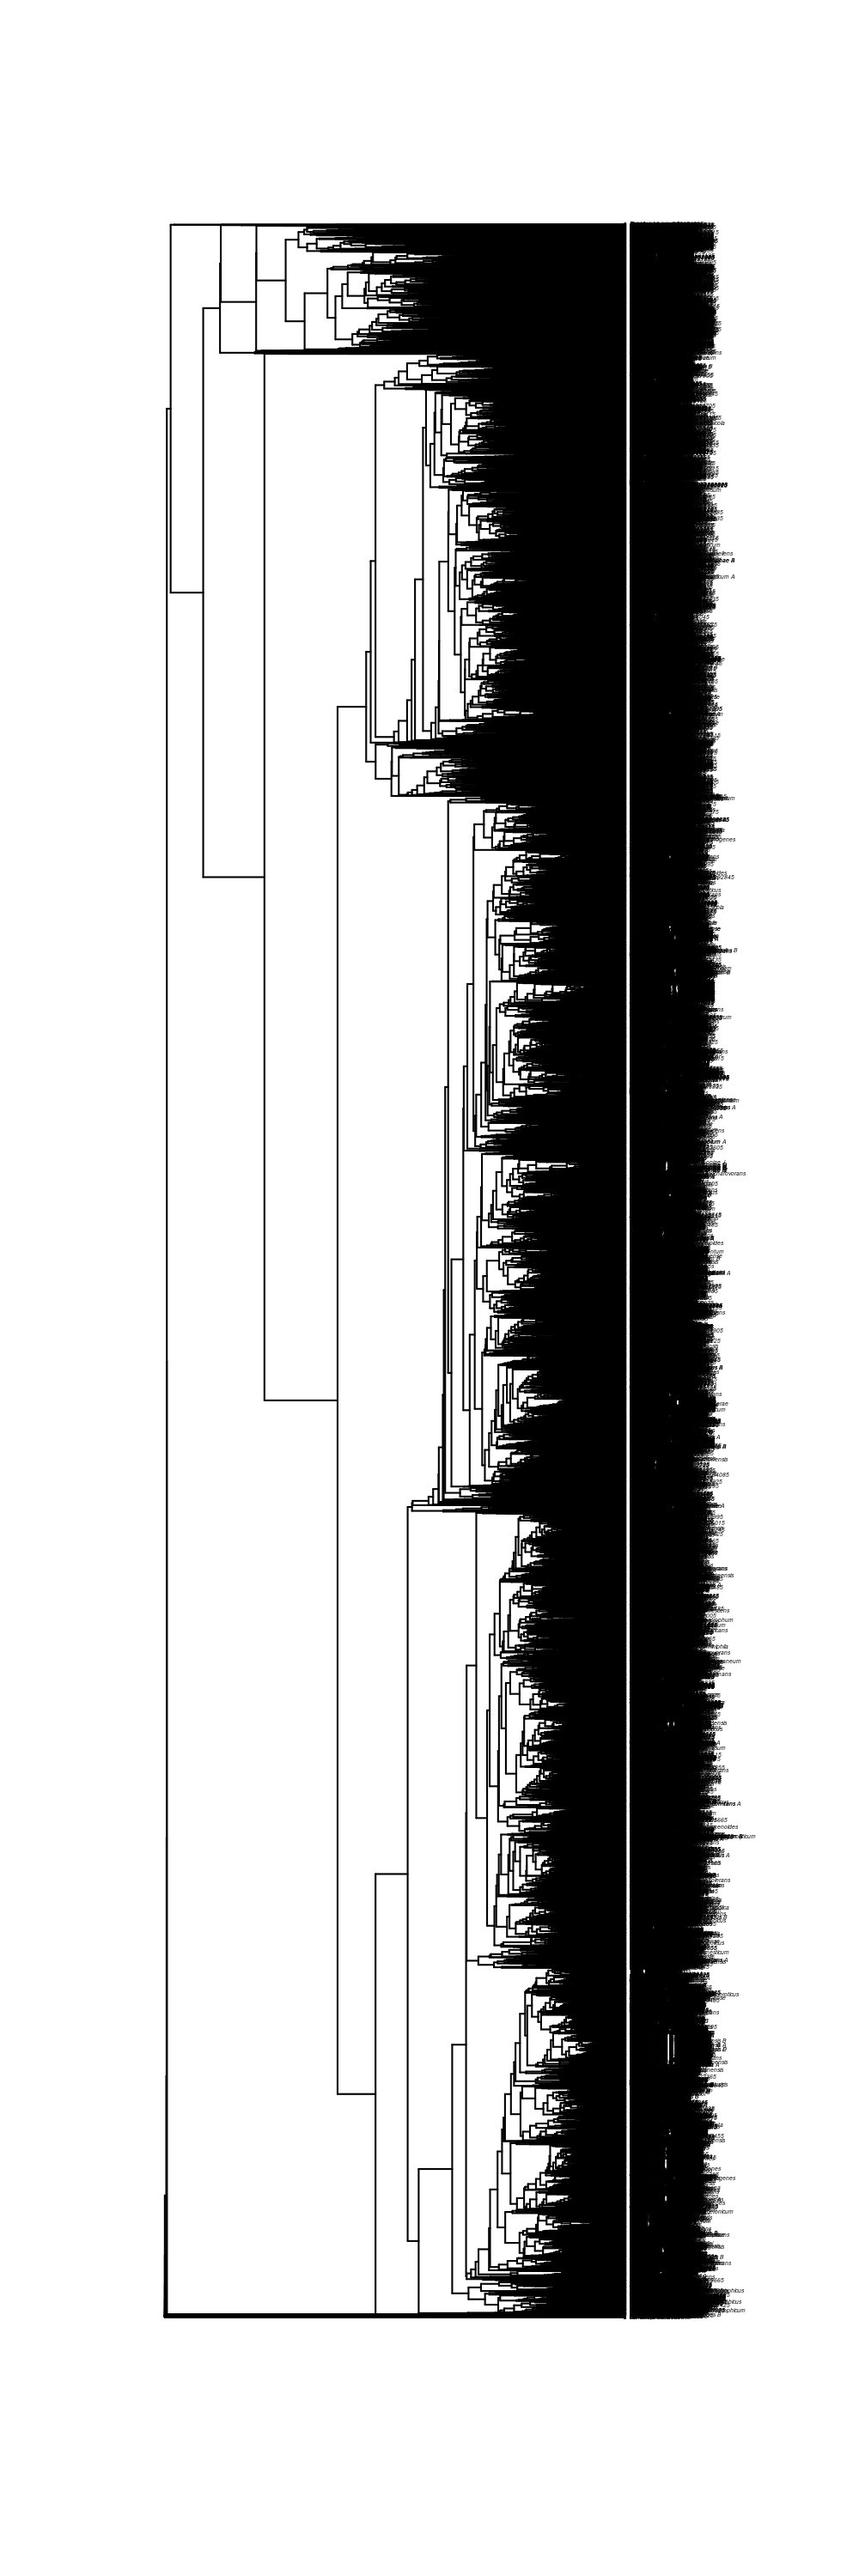

In [205]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.2)

In [206]:
# writing tree
F = file.path(work_dir, 'genes-per-COGcat_jaccard.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-COGcat_jaccard.nwk 


In [207]:
#send_email('http://127.0.0.1:9701/notebooks/ipynb/01_data_explore/08_genome_gene_content.ipynb#Bray-Curtis')

## pfam

In [208]:
# loading mapping table 
cmd = paste(exe, util_map_pfam_file, sep=' ')
pfam_map = Fread(cmd=cmd, sep='\t', header=FALSE) 
colnames(pfam_map) = c('pfam', 'UniRefID')
pfam_map

pfam,UniRefID
<chr>,<chr>
PF00001,UniRef50_A0A015IN71
PF00001,UniRef50_A0A015K6G1
⋮,⋮
PF18507,UniRef50_P46995
PF18507,UniRef50_Q757Y8


In [209]:
# hierarchy
util_map_pfam_h = Fread(util_map_pfam_h_file, header=FALSE)
colnames(util_map_pfam_h) = c('pfam', 'pfam_group')
util_map_pfam_h

pfam,pfam_group
<chr>,<chr>
PF02834,2H
PF08975,2H
⋮,⋮
PF17981,zf-FYVE-PHD
PF16866,zf-FYVE-PHD


In [210]:
# annotations
#cmd = paste('gunzip -c', annot_tbl_file, '| head -n 500001', sep=' ') 
#pfam_annot = Fread(cmd=cmd) %>%
pfam_annot = Fread(annot_tbl_file) %>%
    distinct.(seq_uuid, genome_name, annotation, species) %>%
    #inner_join.(brk, c('species'='name')) %>%
    inner_join.(pfam_map, c('annotation'='UniRefID')) %>%
    left_join.(util_map_pfam_h, c('pfam'))
pfam_annot

seq_uuid,genome_name,annotation,species,pfam,pfam_group
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
35305d1a293a4f18930f7bbb5fe92c54,GCA_002239025.1_ASM223902v1_genomic,UniRef50_A0A0S1YDB3,s__Bin125_sp002239025,PF00001,GPCR_A
5bf072cf8f80422e9db58ea682658ec3,GCA_002239025.1_ASM223902v1_genomic,UniRef50_A0A0S1YDB3,s__Bin125_sp002239025,PF00001,GPCR_A
⋮,⋮,⋮,⋮,⋮,⋮
9cf79a8d62f94220b7948d90adc0efa4,GCA_001316105.1_ASM131610v1_genomic,UniRef50_T0NAN1,s__Thermogymnomonas_acidicola,PF18320,RAMPS-Cas5-like
4e5b823a0c79424189c93ebe3c1e61c5,GCA_003205235.1_ASM320523v1_genomic,UniRef50_T0NAN1,s__Thermoplasma_sp003205235,PF18320,RAMPS-Cas5-like


### Summary

In [211]:
# number of pfam-annotated genes per genome
pfam_annot %>%
    distinct.(seq_uuid, species, pfam) %>%
    summarize.(n_pfam = n.(), by=species) %>%
    .$n_pfam %>% summary_x('pfam annot. genes per genome')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
pfam annot. genes per genome,2,1840,2806,3060.531,4037,10819,3717.917,1517.833


In [212]:
# number of different pfam annotations per genome
pfam_annot %>%
    distinct.(species, pfam) %>%
    summarize.(n_pfam = n.(), by=species) %>%
    .$n_pfam %>% summary_x('pfam annot. per genome')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
pfam annot. per genome,2,1096,1439,1420.969,1788,2557,841,343.337


In [213]:
# number of pfam groups
pfam_annot %>%
    distinct.(pfam_group) %>%
    nrow

[1] 609

#### Genes per pfam

In [214]:
# creating `genome x pfam` matrix
m = pfam_annot %>%
    distinct.(seq_uuid, species, pfam) %>%
    summarize.(n_genes = n.(), by=c(species, pfam)) %>%
    pivot_wider.(pfam, n_genes) %>%
    mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
    as.data.frame
                   
rownames(m) = m$species
m$species = NULL
m

,PF00001,PF00002,PF00003,PF00004,PF00005,PF00006,PF00007,PF00008,PF00009,PF00010,⋯,PF17627,PF17628,PF17629,PF17630,PF17632,PF17633,PF17637,PF17639,PF18205,PF18320
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,2,3,1,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
s__0-14-0-20-30-16_sp002779075,0,0,0,2,4,0,0,0,4,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Zymomonas_mobilis,0,0,0,3,24,4,0,0,6,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Zymomonas_pomaceae,0,0,0,3,24,4,0,0,6,0,⋯,0,0,0,0,0,0,0,0,0,0


In [215]:
# adding missing species
to_add = setdiff(phy$name, rownames(m))
cat('Species to add:', length(to_add), '\n')
if(length(to_add) > 0){
    mx = matrix(rep(0, ncol(m) * length(to_add)),
                ncol=ncol(m),
                nrow=length(to_add)) %>%
        as.data.frame
    rownames(mx) = to_add
    colnames(mx) = colnames(m)
    m = rbind(m, mx)
}
m

Species to add: 0 


,PF00001,PF00002,PF00003,PF00004,PF00005,PF00006,PF00007,PF00008,PF00009,PF00010,⋯,PF17627,PF17628,PF17629,PF17630,PF17632,PF17633,PF17637,PF17639,PF18205,PF18320
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,0,0,2,3,1,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
s__0-14-0-20-30-16_sp002779075,0,0,0,2,4,0,0,0,4,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Zymomonas_mobilis,0,0,0,3,24,4,0,0,6,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Zymomonas_pomaceae,0,0,0,3,24,4,0,0,6,0,⋯,0,0,0,0,0,0,0,0,0,0


##### Writing table

In [216]:
F = file.path(work_dir, 'genes-per-pfam.tsv')
m %>% 
    tibble::rownames_to_column('Taxon') %>%
    write_table(F)

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfam.tsv 


##### Bray Curtis

In [217]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='bray') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd


Phylogenetic tree with 23357 tips and 23356 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19807 
setdiff(y,x): 0 
union(x,y): 23357 


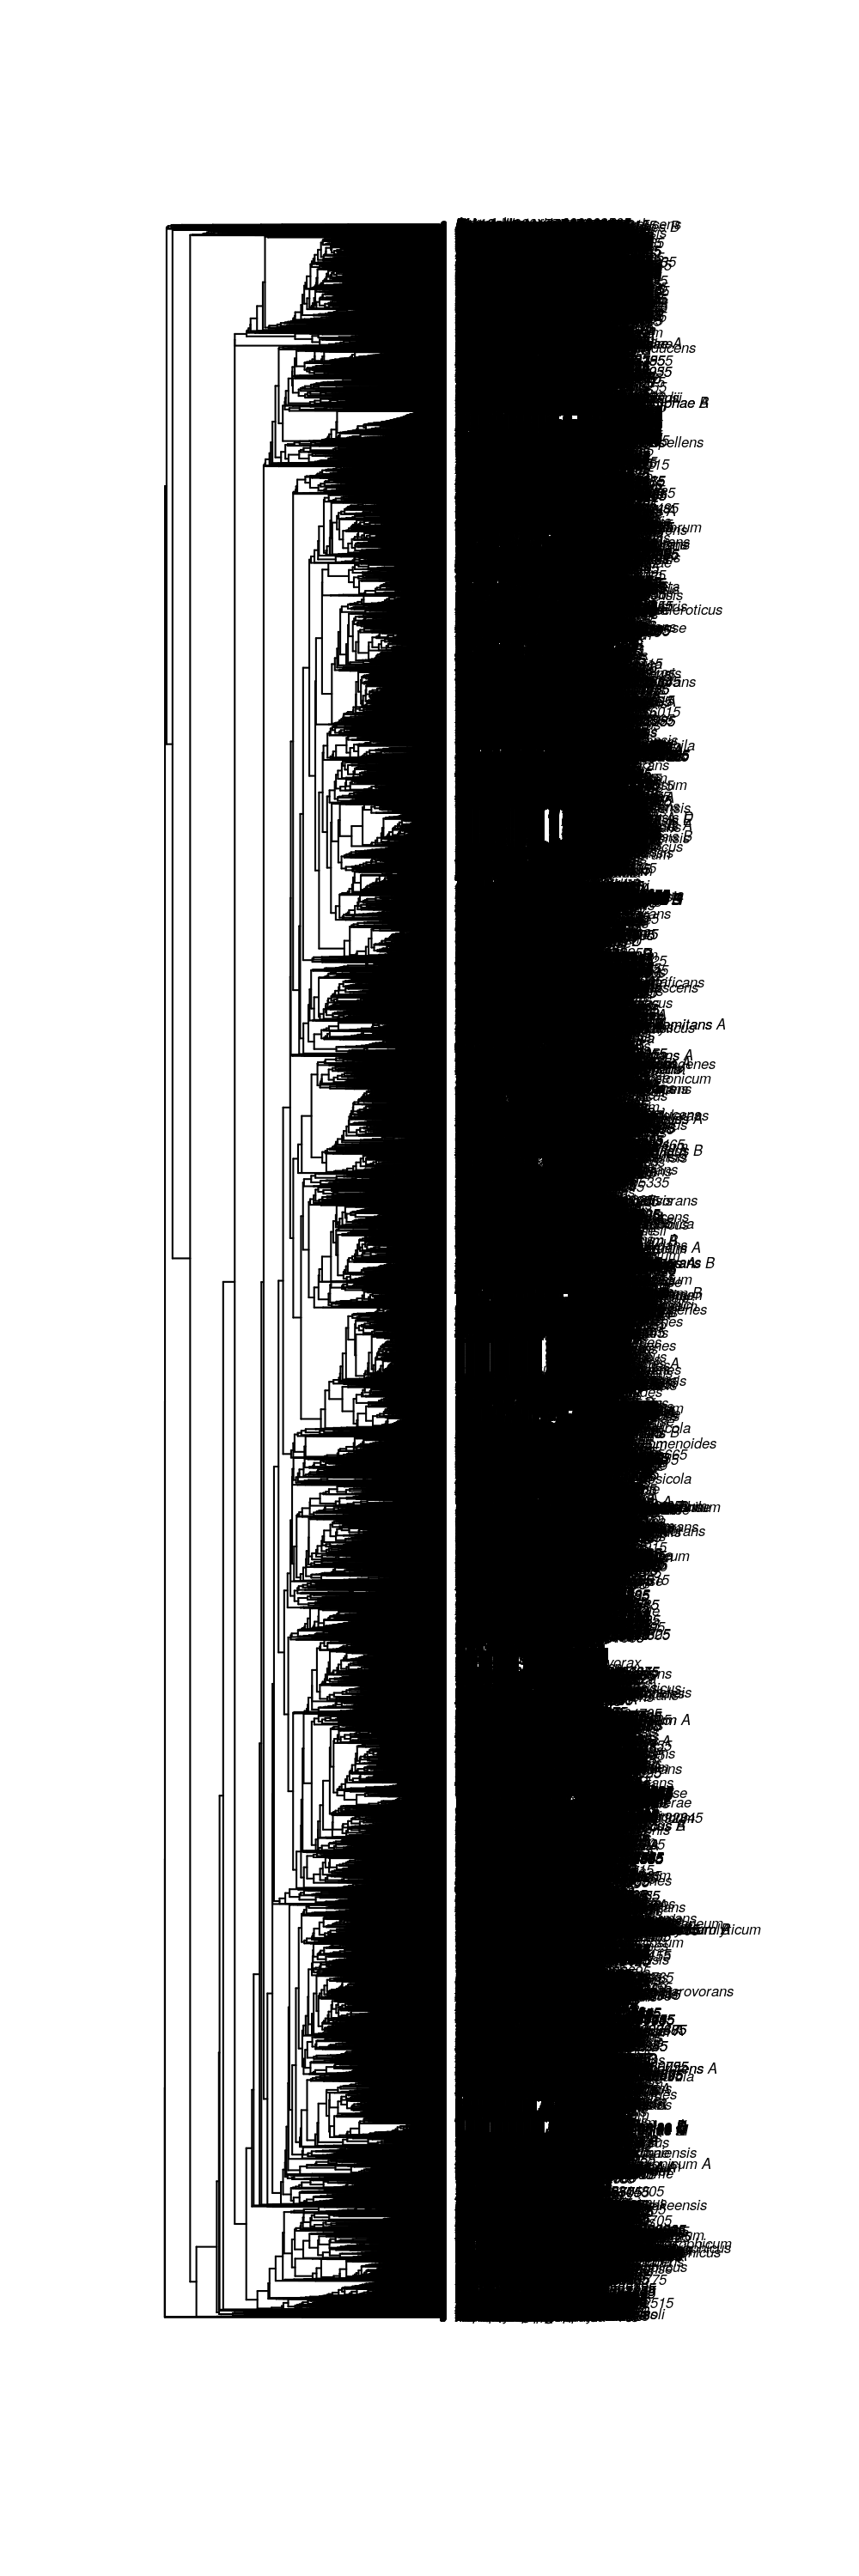

In [218]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.5)

In [219]:
# writing tree
F = file.path(work_dir, 'genes-per-pfam_bray.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfam_bray.nwk 


##### Jaccard

In [220]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='jaccard') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd


Phylogenetic tree with 23357 tips and 23356 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19807 
setdiff(y,x): 0 
union(x,y): 23357 


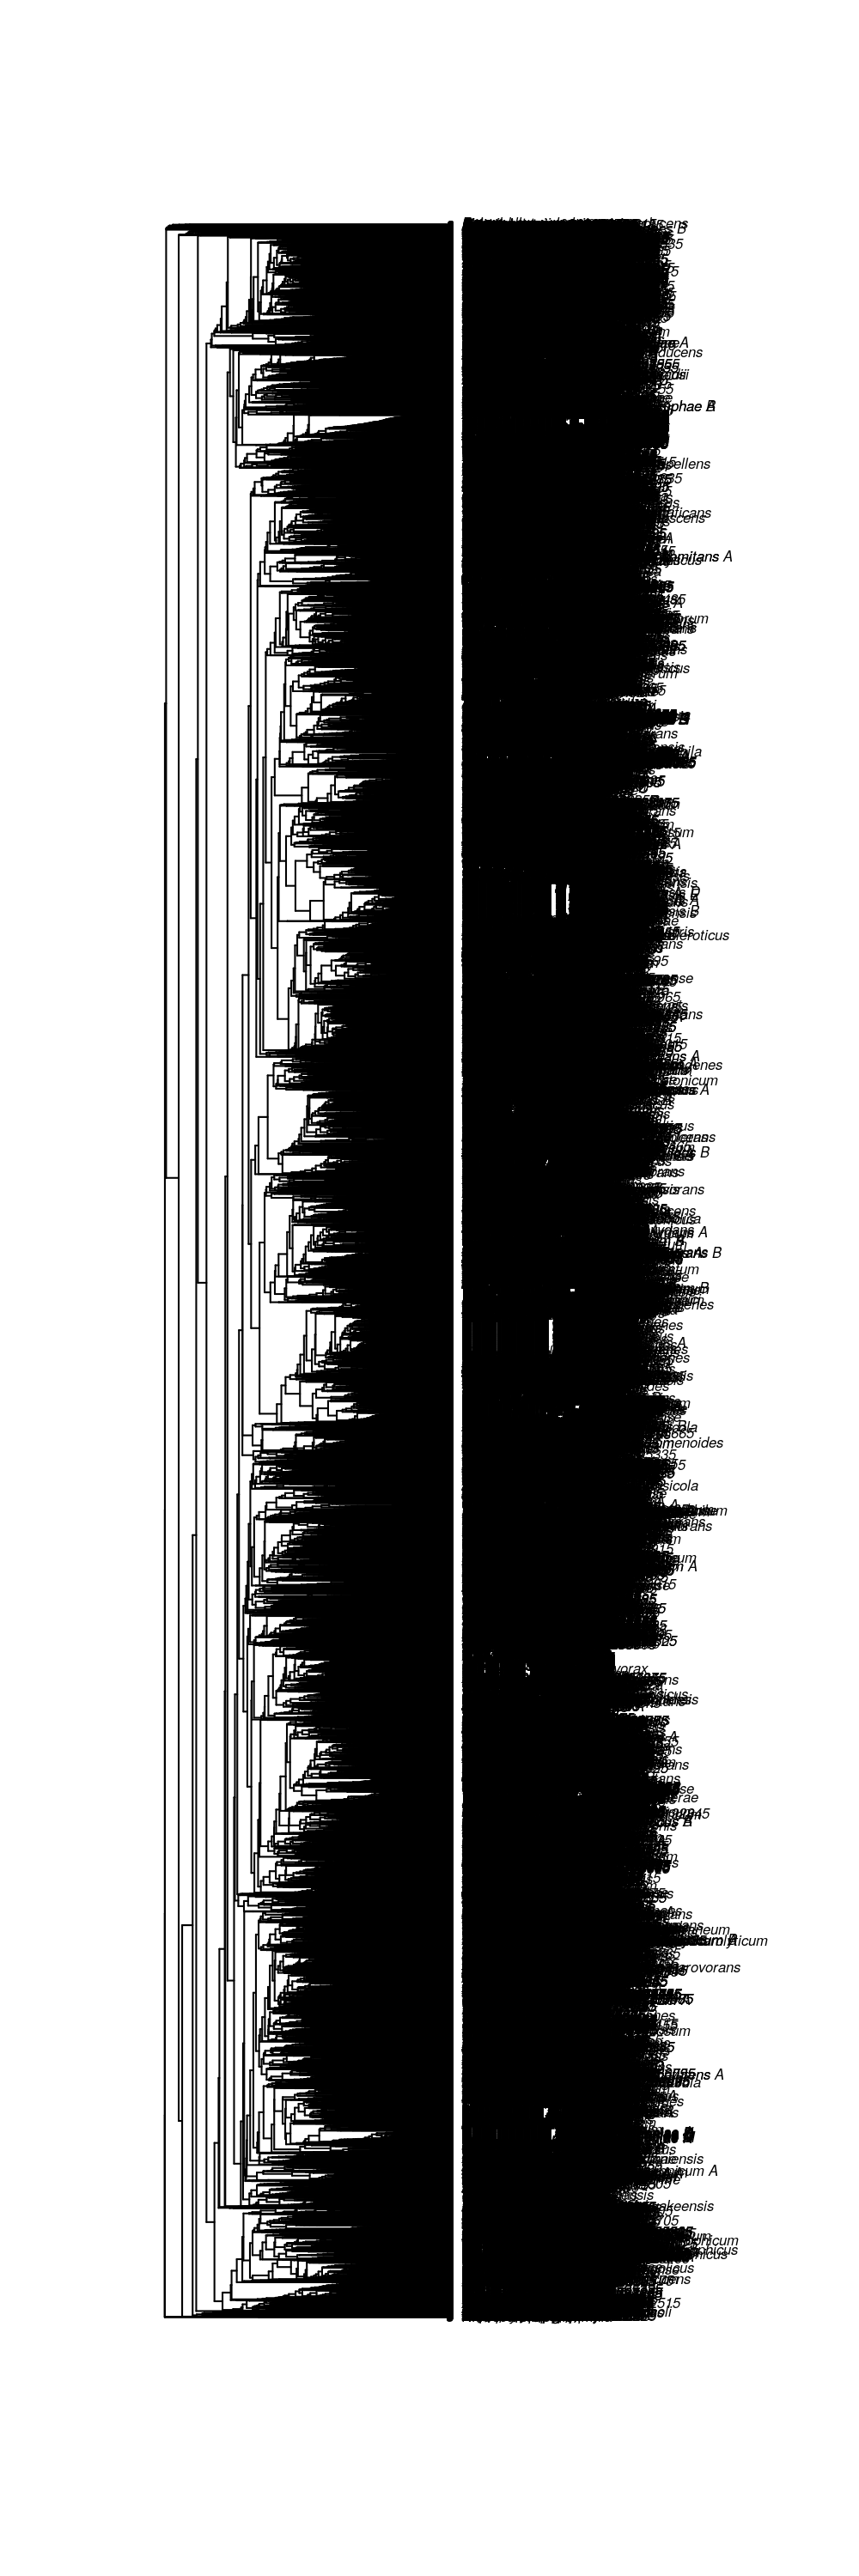

In [221]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.5)

In [222]:
# writing tree
F = file.path(work_dir, 'genes-per-pfam_jaccard.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfam_jaccard.nwk 


#### Genes per pfam group

In [223]:
pfam_annot %>%
    distinct.(seq_uuid, species, pfam_group) %>%
    mutate.(pfam_group = pfam_group %>% as.factor %>% as.numeric) %>%
    summarize.(n_genes = n.(), by=c(species, pfam_group))

species,pfam_group,n_genes
<chr>,<dbl>,<int>
s__Bin125_sp002239025,244,3
s__CAG-306_sp000980375,244,2
⋮,⋮,⋮
s__Spirochaeta_A_thermophila,467,1
s__TCS52_sp001577215,467,1


In [224]:
# creating `genome x pfam` matrix
m = pfam_annot %>%
    distinct.(seq_uuid, species, pfam_group) %>%
    filter.(!is.na(pfam_group)) %>%
    mutate.(pfam_group = pfam_group %>% as.factor %>% as.numeric) %>%
    mutate.(pfam_group = gsub('^', 'X', pfam_group)) %>%
    summarize.(n_genes = n.(), by=c(species, pfam_group)) %>%
    filter.(!is.na(pfam_group)) %>%
    pivot_wider.(pfam_group, n_genes) %>%
    mutate_across.(where(is.numeric), function(x) ifelse(is.na(x), 0, x)) %>%
    as.data.frame
                   
rownames(m) = m$species
m$species = NULL
m

,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,⋯,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,2,0,0,1,0,0,0,0,2,⋯,1,0,0,0,0,0,0,1,0,0
s__0-14-0-20-30-16_sp002779075,1,2,0,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,1,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Zymomonas_mobilis,0,6,0,0,3,0,1,6,0,17,⋯,0,0,0,0,0,1,0,4,0,0
s__Zymomonas_pomaceae,0,7,0,0,3,0,1,10,0,16,⋯,0,0,0,0,0,0,0,3,0,0


In [225]:
# adding missing species
#to_add = setdiff(brk$name, rownames(m))
to_add = setdiff(phy$tip.label, rownames(m))
cat('Species to add:', length(to_add), '\n')
if(length(to_add) > 0){
    mx = matrix(rep(0, ncol(m) * length(to_add)),
                ncol=ncol(m),
                nrow=length(to_add)) %>%
        as.data.frame
    rownames(mx) = to_add
    colnames(mx) = colnames(m)
    m = rbind(m, mx)
}
m

Species to add: 4 


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,⋯,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s__0-14-0-10-38-17_sp002774085,0,2,0,0,1,0,0,0,0,2,⋯,1,0,0,0,0,0,0,1,0,0
s__0-14-0-20-30-16_sp002779075,1,2,0,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,1,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Tenacibaculum_sp002954385,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Acinetobacter_sp000369405,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


##### Writing table

In [226]:
F = file.path(work_dir, 'genes-per-pfamGrp.tsv')
m %>% 
    tibble::rownames_to_column('Taxon') %>%
    write_table(F)

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfamGrp.tsv 


##### Bray-Curtis

In [227]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='bray') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "bray"):
“you have empty rows: their dissimilarities may be meaningless in method “bray””
Warning message in vegan::vegdist(m, method = "bray"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


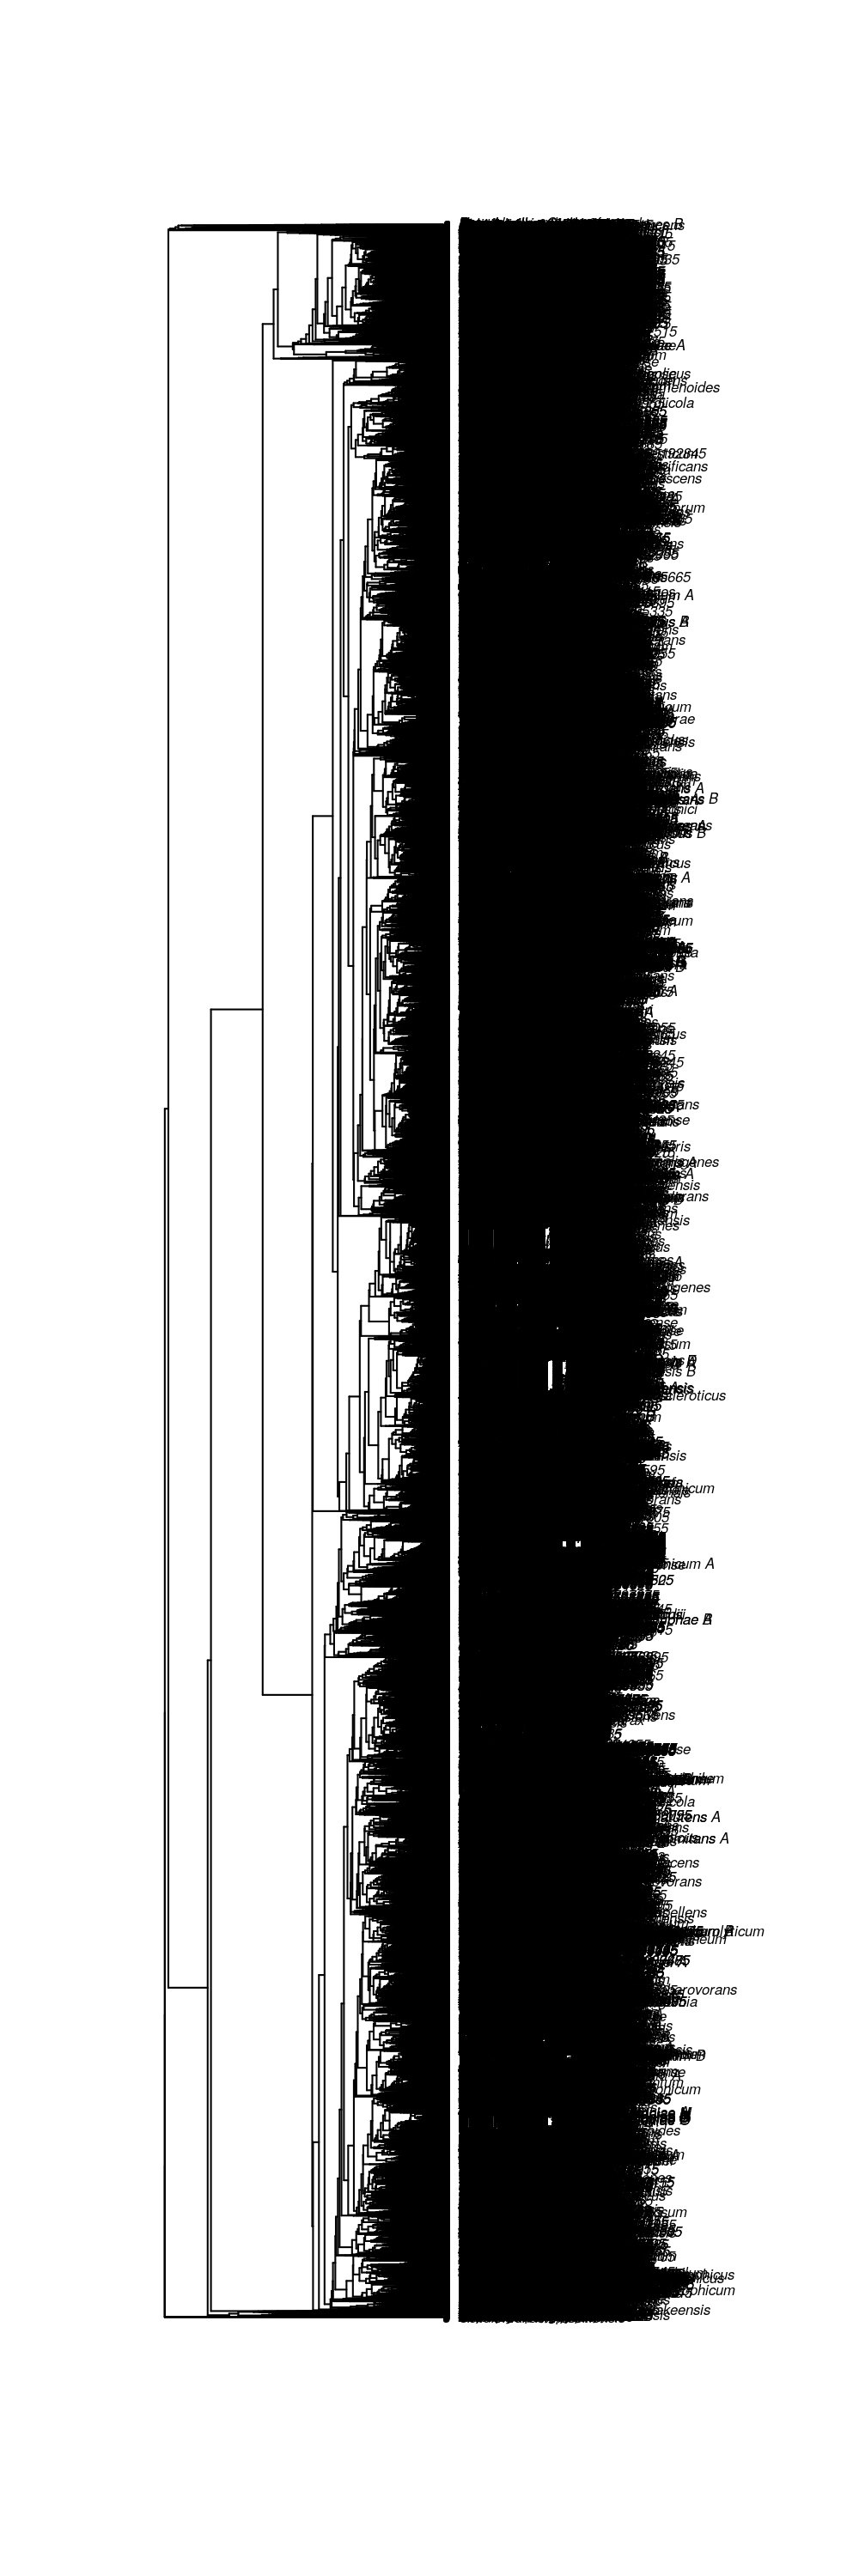

In [228]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.5)

In [229]:
# writing tree
F = file.path(work_dir, 'genes-per-pfamGrp_bray.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfamGrp_bray.nwk 


##### Jaccard

In [230]:
# creating dendrogram
## WARNING: slow
dnd = vegan::vegdist(m, method='jaccard') %>%
    fix_dist_NAs %>%
    hclust(method='average') %>%
    as.phylo
dnd

Warning message in vegan::vegdist(m, method = "jaccard"):
“you have empty rows: their dissimilarities may be meaningless in method “jaccard””
Warning message in vegan::vegdist(m, method = "jaccard"):
“missing values in results”



Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__0-14-0-10-38-17_sp002774085, s__0-14-0-20-30-16_sp002779075, s__0-14-0-20-34-12_sp002779065, s__0-14-0-20-40-13_sp002774285, s__0-14-0-20-44-26_sp002779055, s__0-14-0-20-45-22_sp002774355, ...

Rooted; includes branch lengths.

intersect(x,y): 3550 
setdiff(x,y): 19810 
setdiff(y,x): 0 
union(x,y): 23360 


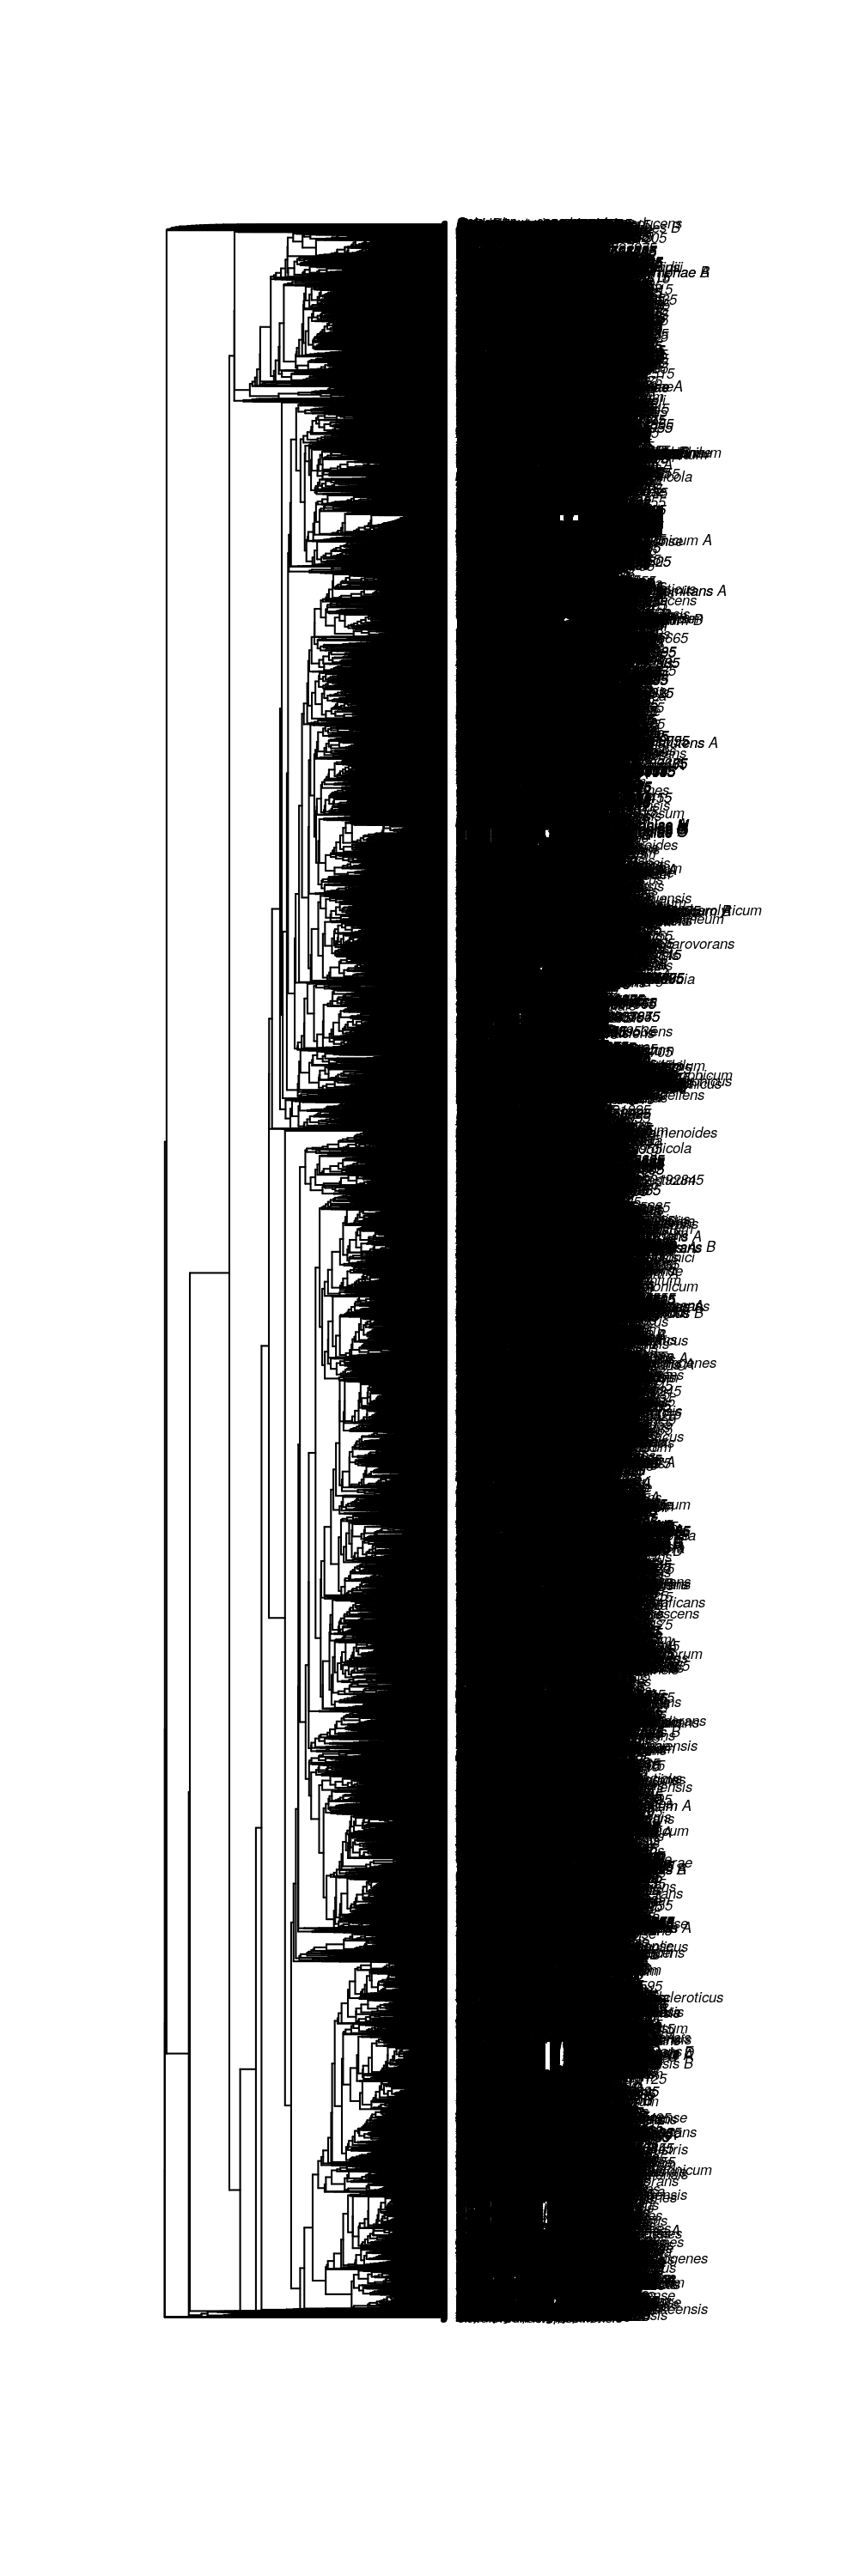

In [231]:
# checking tip labels
overlap(dnd$tip.label, brk$name)
# plotting
p.dims(5,15)
plot(dnd, cex=0.5)

In [232]:
# writing tree
F = file.path(work_dir, 'genes-per-pfamGrp_jaccard.nwk')
write.tree(dnd, file=F)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype//genes-per-pfamGrp_jaccard.nwk 


In [233]:
send_email('http://127.0.0.1:9702/notebooks/ipynb/01_data_explore/08a_genome_gene_content_UniRef50.ipynb')

Sending email to: nyoungblut@tuebingen.mpg.de



# sessionInfo

In [8]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects2/global_metagenome_diversity/envs/phyloseq/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] LeyLabRMisc_0.2.0 ape_5.5           tidytable_0.6.5   data.table_1.14.0
[5] ggplot2_3.3.5     tidyr_1.1.3       dplyr_1.0.7      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7          pillar_1.6.2        compiler_4.1.1     
 [4] R.methodsS3_1.8.1   R.utils_2